# Imports

In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from ipywidgets import interact, widgets
from IPython.display import display

import sys
sys.path.append('../')
sys.path.append('../../')

# Pre-processing

In [43]:
#df_irv = pd.read_parquet(r"C:\Users\theot\Documents\Lafer\Codigos\ConditionMonitoring2023\3_Modeling\Datasets\df_ETL_VI_5_Maint_2183731.parquet") 
df_irv = pd.read_parquet(r"C:\Users\theot\Documents\Lafer\Codigos\ConditionMonitoring2023\3_Modeling\Datasets\df_ETL_VI_5_Maint_2143372.parquet")  

#Drop useless columns
df_irv.drop(['DQ_WeightClass', 'DQ_V_Low', 'DQ_V_High',
       'DQ_SS_Sparse_Vals', 'DQ_Z_Cluster_V', 'DQ_LevelShift_V',
       'DQ_P_Peaks_Width', 'DQ_V_Peaks_Width', 'DQ_P_Peaks_UA_Width',
       'DQ_V_Peaks_UA_Width', 'DQ_P_Greater_110', 'DQ_Trend_UA',
       'DQ_LevelShift_UA', 'DQ_SS_Z_AR_Loose', 'DQ_SS_Z_AL_Loose',
       'DQ_SS_Z_BR_Loose', 'DQ_SS_Z_BL_Loose',
       'WagonNumber', 'Year', 'Month', 'Week_Num', 'Day',
       'Latitude', 'Longitude','Elevation','DQ_Line',
       'Contaminated_Data','DQ_Score', 'DQ_Problems',
       'Region', 'Velocity', 'VelClass','Eh', 'Element', 'Haversini_KmIni',
       'Haversini_KmFim', 'KmReference', 'Radius', 'TrackType', 'CurveClass',
       'Bridge', 'Tunnel', 'Transition', 'Patios', 'MaterialWeight',
       'TotalWeight', 'WeightClass', 'Maint_label', 'Detection Date',
       'End of Maint. Date', 'Description', 'Symptom', 'Cause', 'DefectType',
       'DefectKmIni', 'DefectKmFim', 'DefectExtension', 'MaintDistance',
       'SS_Z_Filt_AR', 'SS_Z_Filt_AL', 'SS_Z_Filt_BR', 'SS_Z_Filt_BL',
       'Pressure', 'Voltage', 'SuspTravel_L', 'SuspTravel_R', 'SuspTravel',
       'Front_Bounce_SS', 'Back_Bounce_SS', 'Bounce', 'Front_Roll_SS',
       'Back_Roll_SS', 'Roll', 'UA_Z_L', 'UA_Z_R', 'UA_Z_Max', 'UA_Z_Abs_Max',
       'KmIni', 'KmFim', 'DQ_Z_Cluster', 'DQ_Bad_Trips'
       ], axis=1, inplace=True, errors='ignore')

df_irv['TripNumber'] = df_irv['TripNumber'].astype(int)
df_irv.rename(columns={'Haversini_Linha':'Line'}, inplace = True)
df_irv.rename(columns={'TripNumber':'Trip'}, inplace = True)
df_irv["Line"] = df_irv["Line"].str.extract(r"(\d+)").astype(int)

sensor_columns = ['UA_Z_AR', 'UA_Z_AL', 'UA_Z_BR', 'UA_Z_BL']

def normalize_timestamps(df):
    # Step 1: strip the date, keep only the time
    df['Timestamp'] = df['Timestamp'].str[11:]
    df['Timestamp'] = pd.to_datetime(df['Timestamp'], format='%H:%M:%S')

    grouped = df.groupby(['Line', 'Trip'])
    new_groups = []

    for _, group in grouped:
        group = group.sort_values("Distance").copy()

        if len(group) < 2:
            continue  # or handle single-row case as needed

        t0 = group['Timestamp'].iloc[0]
        t1 = group['Timestamp'].iloc[1]
        diff = (t1 - t0).total_seconds()

        delta = (group['Timestamp'] - t0).dt.total_seconds()

        if diff >= 0:
            delta = delta.where(delta >= 0, delta + 86400)
        else:
            delta = -delta
            delta = delta.where(delta >= 0, delta + 86400)

        group['Timestamp'] = delta.astype(int)
        new_groups.append(group)

    # Final step: Concatenate groups and overwrite df in-place
    result_df = pd.concat(new_groups).sort_index()
    df.loc[:, :] = result_df.values

normalize_timestamps(df_irv)

C:\Users\theot\AppData\Local\Temp\ipykernel_28880\2114638281.py:65: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[0. 1. 2. ... 3. 2. 0.]' has dtype incompatible with datetime64[ns], please explicitly cast to a compatible dtype first.
  df.loc[:, :] = result_df.values


In [44]:
df_irv.columns

Index(['Timestamp', 'Trip', 'Distance', 'UA_Z_AR', 'UA_Z_AL', 'UA_Z_BR',
       'UA_Z_BL', 'Line', 'DQ_Score_Normalized'],
      dtype='object')

In [45]:
df_irv

,Timestamp,Trip,Distance,UA_Z_AR,UA_Z_AL,UA_Z_BR,UA_Z_BL,Line,DQ_Score_Normalized
0,0.0,1,28.007,0.315308,0.495484,-0.315308,0.540528,2,1.00
1,1.0,1,28.021,0.450440,1.576540,0.720704,0.540528,2,1.00
2,2.0,1,28.034,1.306276,0.585572,-0.630616,-0.585572,2,1.00
3,3.0,1,28.047,1.261232,0.720704,-0.540528,0.540528,2,1.00
4,4.0,1,28.061,0.135132,1.396364,0.405396,-0.585572,2,1.00
...,...,...,...,...,...,...,...,...,...
703206,5.0,22,123.075,1.666628,1.711672,14.819476,1.801760,1,0.81
703207,4.0,22,123.064,1.216188,4.324224,15.810444,4.594488,1,0.81
703208,3.0,22,123.054,4.774664,1.351320,12.206924,1.306276,1,0.81
703209,2.0,22,123.044,4.279180,3.873784,14.819476,4.099004,1,0.81


# Gap Analisys

Mean interval: 0.74941
Min interval: 0.00000
Max interval: 1.00000
Quantiles:
  1%: 0.19000
  5%: 0.31000
  25%: 0.56000
  50%: 0.81000
  75%: 1.00000
  95%: 1.00000
  99%: 1.00000

Excluded 0 intervals above 1.0.


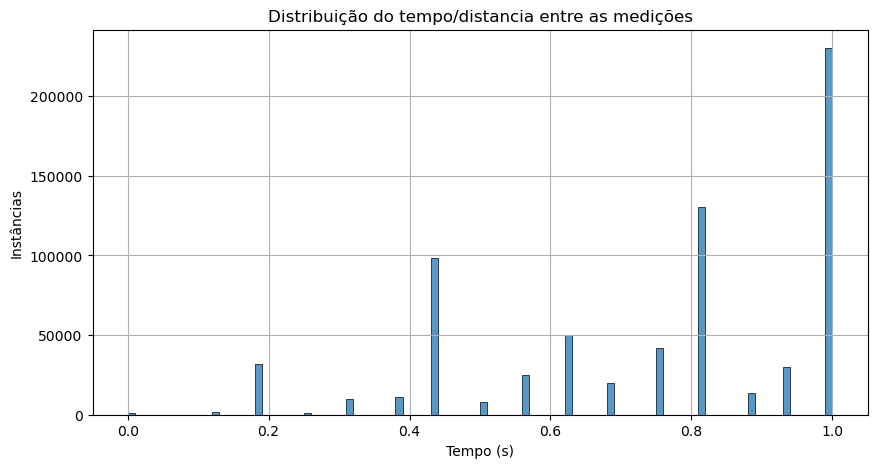

In [46]:
def plot_distance_interval_distribution(df_irv, parameter, quantile_threshold=0.99):
    interval_list = []

    grouped = df_irv.groupby(['Line', 'Trip'])

    for (line, trip), group in grouped:

        if parameter == "Time":
            group_sorted = group.sort_values('Timestamp')
            time_diff = group_sorted['Timestamp'].diff().dropna()
            interval_list.extend(time_diff.tolist())
        elif parameter == "Distance":
            group_sorted = group.sort_values('Distance')
            time_diff = group_sorted['Distance'].diff().dropna()
            interval_list.extend(time_diff.tolist())
        elif parameter == "DQ_Score":
            DQ_group_values = group["DQ_Score_Normalized"]
            interval_list.extend(DQ_group_values.tolist())

    # Convert to numpy array for easy stats
    intervals = np.array(interval_list)

    # Filter by quantile threshold
    threshold_value = np.quantile(intervals, quantile_threshold)

    filtered_intervals = intervals[intervals <= threshold_value]
    excluded_count = len(intervals) - len(filtered_intervals)

    # Print statistics
    print(f"Mean interval: {np.mean(filtered_intervals):.5f}")
    print(f"Min interval: {np.min(filtered_intervals):.5f}")
    print(f"Max interval: {np.max(filtered_intervals):.5f}")
    print("Quantiles:")
    for q in [0.01, 0.05, 0.25, 0.5, 0.75, 0.95, 0.99]:
        print(f"  {int(q*100)}%: {np.quantile(filtered_intervals, q):.5f}")
    print(f"\nExcluded {excluded_count} intervals above {threshold_value}.")

    # Plot the distribution
    plt.figure(figsize=(10, 5))
    sns.histplot(filtered_intervals, bins=100, kde=False)
    plt.title("Distribuição do tempo/distancia entre as medições")
    plt.xlabel("Tempo (s)")
    plt.ylabel("Instâncias")
    plt.grid(True)
    plt.show()

plot_distance_interval_distribution(df_irv, parameter="DQ_Score", quantile_threshold=0.9999)

# Timeseries Visualization

In [ ]:
plot_df = df_irv

# ---- Widget Definitions ----
line_dropdown = widgets.Dropdown(
    options=sorted(plot_df['Line'].unique()),
    description='Line:',
    continuous_update=False
)

trip_dropdown = widgets.Dropdown(
    description='Trip:',
    continuous_update=False
)

column_dropdown = widgets.Dropdown(
    options=sensor_columns,
    description='Column:',
    continuous_update=False
)

start_slider = widgets.IntSlider(
    value=0,
    min=0,
    max=int(plot_df['Distance'].max()),
    step=1,
    description='Start:',
    continuous_update=False
)

window_slider = widgets.IntSlider(
    value=100,
    min=10,
    max=1000,
    step=10,
    description='Window:',
    continuous_update=False
)

# ---- Update trips based on selected line ----
def update_trip_options(*args):
    selected_line = line_dropdown.value
    trips = plot_df[plot_df['Line'] == selected_line]['Trip'].unique()
    trip_dropdown.options = sorted(trips)

line_dropdown.observe(update_trip_options, names='value')
update_trip_options()

# ---- Plotting function ----
def plot_ts(line, trip, column, start, window):
    subset = plot_df[(plot_df['Line'] == line) & (plot_df['Trip'] == trip)].copy()

    # Find the row closest to the start distance
    start_idx = (subset['Distance'] - start).abs().idxmin()
    start_pos = subset.index.get_loc(start_idx)

    # Extract window of rows
    selected = subset.iloc[start_pos:start_pos + window]

    x = selected['Distance'].values
    y = selected[column].values

    plt.figure(figsize=(12, 4))
    for i in range(len(x) - 1):
        color = 'red' if (x[i+1] - x[i]) > 0.02 else 'blue'
        plt.plot(x[i:i+2], y[i:i+2], color=color)
    
    plt.xlabel('Distance (km)')
    plt.ylabel(column)
    plt.title(f'{column} | Line {line}, Trip {trip}')
    plt.grid(True)
    plt.show()

# ---- Interactive Display ----
interact(plot_ts,
         line=line_dropdown,
         trip=trip_dropdown,
         column=column_dropdown,
         start=start_slider,
         window=window_slider)

interactive(children=(Dropdown(description='Line:', options=(1, 2), value=1), Dropdown(description='Trip:', op…

<function __main__.plot_ts(line, trip, column, start, window)>

# Separate normal and anomalous data

In [51]:
def separate_by_DQ_Score(df, DQ_threshold):
    """
    Separates the dataframe into two based on DQ_Score_Normalized,
    groups each result by ['trip', 'line'], and sorts within each group by 'Distance'.

    Parameters:
    - df: pandas.DataFrame, must contain 'DQ_Score_Normalized', 'trip', 'line', and 'Distance'
    - DQ_threshold: float

    Returns:
    - df_defect: DataFrame with rows where DQ_Score_Normalized < threshold
    - df_normal: DataFrame with rows where DQ_Score_Normalized >= threshold
    """
    # Apply threshold filter
    df_normal = df[df['DQ_Score_Normalized'] >= DQ_threshold].copy()
    df_defect = df[df['DQ_Score_Normalized'] < DQ_threshold].copy()

    # Group by trip and line, then sort by Distance
    df_normal = (
        df_normal
        .groupby(['Trip', 'Line'], group_keys=False)
        .apply(lambda g: g.sort_values('Distance'))
    )
    
    df_defect = (
        df_defect
        .groupby(['Trip', 'Line'], group_keys=False)
        .apply(lambda g: g.sort_values('Distance'))
    )

    return df_defect, df_normal

df_defect, df_normal = separate_by_DQ_Score(df_irv, 1)

C:\Users\theot\AppData\Local\Temp\ipykernel_28880\1270149314.py:22: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: g.sort_values('Distance'))
C:\Users\theot\AppData\Local\Temp\ipykernel_28880\1270149314.py:28: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: g.sort_values('Distance'))


In [52]:
df_defect

,Timestamp,Trip,Distance,UA_Z_AR,UA_Z_AL,UA_Z_BR,UA_Z_BL,Line,DQ_Score_Normalized
3980,432.0,1,82.167,10.540296,8.198008,8.783580,-3.468388,1,0.81
3981,433.0,1,82.184,-8.333140,-2.026980,-11.125868,6.216072,1,0.81
3991,443.0,1,82.348,-5.765632,4.774664,-6.711556,-3.243168,1,0.81
4408,862.0,1,89.096,14.053728,-9.098888,15.044696,-7.972788,1,0.81
4409,863.0,1,89.112,-12.432144,15.450092,-13.873552,13.513200,1,0.81
...,...,...,...,...,...,...,...,...,...
672529,37521.0,22,521.013,0.540528,1.036012,13.738420,1.216188,2,0.81
672528,37522.0,22,521.020,-1.846804,1.036012,10.134900,-0.495484,2,0.81
672527,37524.0,22,521.035,4.639532,-3.243168,15.945576,3.558476,2,0.81
672526,37525.0,22,521.043,-4.279180,5.225104,7.972788,-2.882816,2,0.81


In [53]:
df_normal

,Timestamp,Trip,Distance,UA_Z_AR,UA_Z_AL,UA_Z_BR,UA_Z_BL,Line,DQ_Score_Normalized
3548,0.0,1,75.398,1.756716,2.972904,-1.171144,2.297244,1,1.0
3549,1.0,1,75.413,-0.585572,-0.585572,1.891848,-2.162112,1,1.0
3550,2.0,1,75.428,2.792728,2.297244,5.450324,-3.108036,1,1.0
3551,3.0,1,75.444,-0.810792,-0.360352,-5.135016,3.333256,1,1.0
3552,4.0,1,75.459,8.198008,-2.162112,4.008916,-2.162112,1,1.0
...,...,...,...,...,...,...,...,...,...
546361,36633.0,18,514.819,2.252200,1.306276,1.936892,0.990968,2,1.0
545030,38253.0,18,531.359,0.900880,0.585572,0.225220,0.360352,2,1.0
545017,38475.0,18,534.513,0.855836,1.711672,-0.180176,1.576540,2,1.0
545011,38481.0,18,534.597,2.026980,1.891848,0.720704,1.711672,2,1.0


# Extract windows

In [55]:
class ValidWindow:
    def __init__(self, signal_matrix, sensor_names, line, trip, km_start, km_end):
        self.line = line
        self.trip = trip
        self.km_start = km_start
        self.km_end = km_end

        # Unpack each sensor row into attributes
        for i, name in enumerate(sensor_names):
            setattr(self, name, signal_matrix[i])


class ValidWindowExtractor:
    def __init__(self, df, window_size=128, step_size=64, max_gap=0.025):
        self.df = df.copy()
        self.window_size = window_size
        self.step_size = step_size
        self.max_gap = max_gap
        self.sensor_cols = ['UA_Z_AR', 'UA_Z_AL', 'UA_Z_BR', 'UA_Z_BL']

    def extract(self):
        windows = []

        # Sort and group
        df_sorted = self.df.sort_values(['Line', 'Trip', 'Distance']).reset_index(drop=True)
        grouped = df_sorted.groupby(['Line', 'Trip'])

        for (line, trip), group in grouped:
            group = group.reset_index(drop=True)
            distances = group['Distance'].to_numpy()
            signals = group[self.sensor_cols].to_numpy().T  # shape (4, N)
            n = group.shape[0]
            i = 0

            while i + self.window_size <= n:
                dist_window = distances[i:i + self.window_size]
                dist_diff = np.diff(dist_window)

                if np.any(dist_diff > self.max_gap):
                    # Skip past the gap
                    bad_gap_idx = np.argmax(dist_diff > self.max_gap) + 1
                    i += bad_gap_idx
                    continue

                # Window is valid
                signal_window = signals[:, i:i + self.window_size]  # shape (4, window_size)
                km_start = dist_window[0]
                km_end = dist_window[-1]

                window_obj = ValidWindow(
                    signal_matrix=signal_window,
                    sensor_names=self.sensor_cols,
                    line=line,
                    trip=trip,
                    km_start=km_start,
                    km_end=km_end
                )
                windows.append(window_obj)

                i += self.step_size

        return windows

In [57]:
extractor = ValidWindowExtractor(df_normal, window_size=128, step_size=32, max_gap=0.025)
normal_windows = extractor.extract()

extractor = ValidWindowExtractor(df_defect, window_size=128, step_size=32, max_gap=0.025)
defect_windows = extractor.extract()

num_windows = len(normal_windows)
print(f"Total normal windows extracted: {num_windows}")

num_windows = len(defect_windows)
print(f"Total defect windows extracted: {num_windows}")

#normal_windows[i].UA_Z_AR
#normal_windows[i].UA_Z_AL
#normal_windows[i].UA_Z_BR
#normal_windows[i].UA_Z_BL
#normal_windows[i].line
#normal_windows[i].trip
#normal_windows[i].km_start
#normal_windows[i].km_end

Total normal windows extracted: 2640
Total defect windows extracted: 6912


# Extract Scaling factor

In [94]:
def get_sensor_distribution(df: pd.DataFrame, sensor: str, bins: int = 50, percentile_lim: float = 99):
    """
    Computes a normalized histogram of the absolute values of a sensor,
    optionally excluding values above a given percentile.

    Parameters:
    - df: Input DataFrame
    - sensor: Name of the sensor column
    - bins: Number of histogram bins
    - percentile_lim: Upper percentile limit for filtering (default=100)

    Returns:
    - bin_centers: Array of bin center values
    - counts: Normalized array (sum = 1) of counts per bin
    """
    values = np.abs(df[sensor].to_numpy())

    if percentile_lim < 100:
        threshold = np.percentile(values, percentile_lim)
        values = values[values <= threshold]

    counts, bin_edges = np.histogram(values, bins=bins, density=False)

    total = counts.sum()
    counts = counts / total

    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

    return bin_centers, counts

In [95]:
def plot_two_distributions(
    bins1, counts1,
    bins2, counts2,
    label1="Normal",
    label2="Anomalous",
    title="Distribuições de Valores do Sensor",
    xlabel="Valor",
    ylabel="Contagem (normalizada)",
    color1="blue",
    color2="red"
):
    """
    Plots two sensor value distributions on the same axes.

    Parameters:
    - bins1, counts1: Bin centers and counts for distribution 1
    - bins2, counts2: Bin centers and counts for distribution 2
    - label1, label2: Labels for the legend
    - color1, color2: Colors for each line
    """
    plt.figure(figsize=(8, 5))
    plt.plot(bins1, counts1, label=label1, color=color1, linewidth=2)
    plt.plot(bins2, counts2, label=label2, color=color2, linewidth=2)
    
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

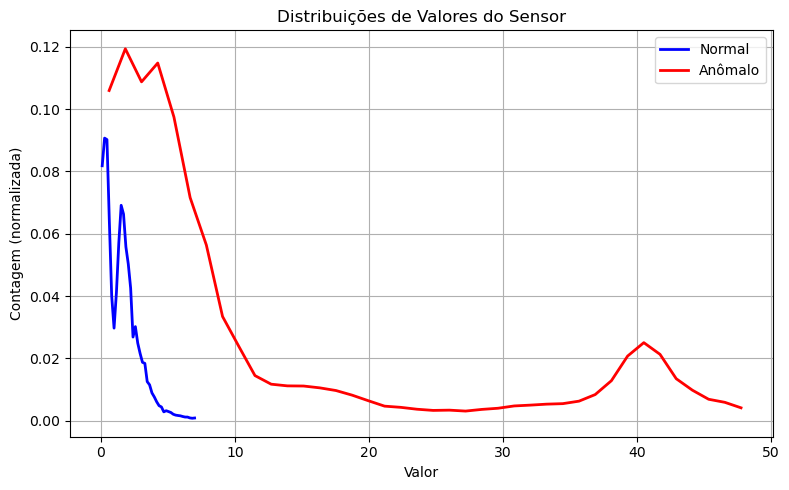

In [96]:
centers_AR_normal, counts_AR_normal = get_sensor_distribution(df_normal, "UA_Z_AR", bins=40)
centers_AR_defect, counts_AR_defect = get_sensor_distribution(df_defect, "UA_Z_AR", bins=40)

plot_two_distributions(
    centers_AR_normal*1, counts_AR_normal,
    centers_AR_defect, counts_AR_defect,
    label1="Normal", label2="Anômalo"
)

In [ ]:
def plot_three_distributions(
    bins1, counts1,
    bins2, counts2,
    bins3, counts3,
    label1="Normal",
    label2="Anomalous",
    label3="NormalScaled",
    title="Distribuições de Valores do Sensor",
    xlabel="Valor",
    ylabel="Contagem (normalizada)",
    color1="blue",
    color2="red",
    color3="green"
):
    plt.figure(figsize=(8, 5))
    plt.plot(bins1, counts1, label=label1, color=color1, linewidth=1)
    plt.plot(bins2, counts2, label=label2, color=color2, linewidth=1)
    plt.plot(bins3, counts3, label=label3, color=color3, linewidth=1, )    

    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

timestamp = np.arange(128)

i = 4

plot_three_distributions(
    timestamp, normal_windows[i].UA_Z_AR,
    timestamp, defect_windows[i].UA_Z_AR,
    timestamp, normal_windows[i].UA_Z_AR*1
)

# Jitter study

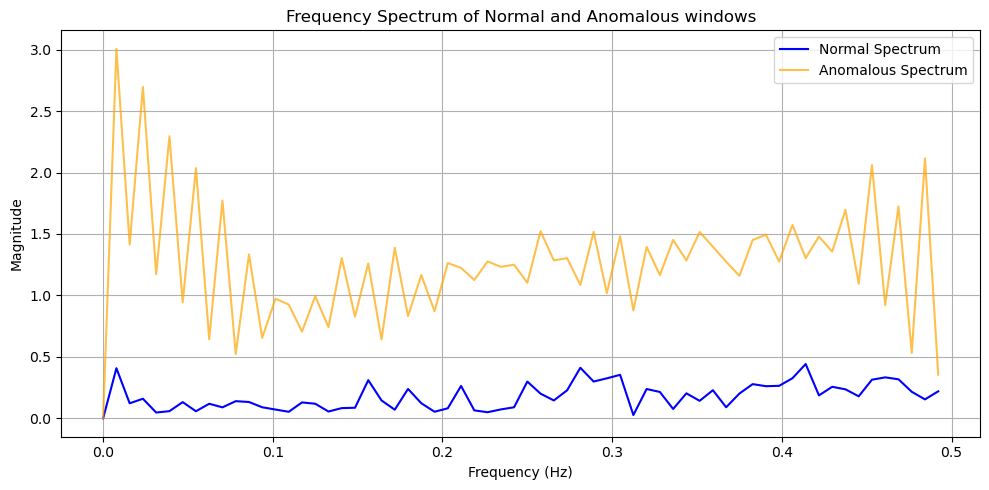

In [98]:
i_norm = 657
i_anom = 210
window_size = 128

hanning_window = np.hanning(128)

# Generate clean sine wave
window_normal = normal_windows[i_norm].UA_Z_AR - np.mean(normal_windows[i_norm].UA_Z_AR)
window_anomalous = defect_windows[i_anom].UA_Z_AR - np.mean(defect_windows[i_anom].UA_Z_AR)

# FFT of both signals
fft_normal = np.fft.fft(window_normal)
fft_anomalous = np.fft.fft(window_anomalous)

# Frequency axis
freqs = np.fft.fftfreq(window_size, d=1)

# Take only the positive half of frequencies
positive_freqs = freqs[:len(freqs)//2]
spectrum_normal = np.abs(fft_normal[:len(freqs)//2])
spectrum_anomalous = np.abs(fft_anomalous[:len(freqs)//2])

# Plotting
plt.figure(figsize=(10, 5))
plt.plot(positive_freqs, spectrum_normal*(2/window_size), label='Normal Spectrum', color='blue')
plt.plot(positive_freqs, spectrum_anomalous*(2/window_size), label='Anomalous Spectrum', color='orange', alpha=0.7)
plt.title('Frequency Spectrum of Normal and Anomalous windows')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Magnitude')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

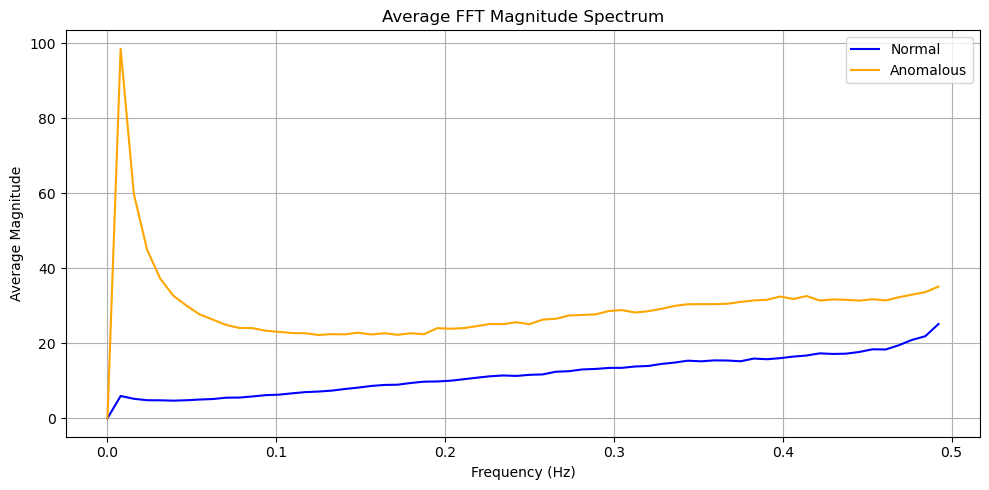

2.545344943698643


In [93]:
# Parameters
window_size = 128
sampling_rate = 1  # samples per second
N = window_size

hanning_window = np.hanning(128)

# Frequency axis (positive half)
freqs = np.fft.fftfreq(N, d=1/sampling_rate)[:N//2]

# Accumulators for spectra
normal_spectra = []
defect_spectra = []

# Process normal windows
for w in normal_windows:
    signal = w.UA_Z_AR - np.mean(w.UA_Z_AR)
    fft_result = np.fft.fft(signal)
    #fft_result = np.fft.fft(signal*hanning_window)
    magnitude = np.abs(fft_result[:N//2])
    normal_spectra.append(magnitude)

# Process defect windows
for w in defect_windows:
    signal = w.UA_Z_AR - np.mean(w.UA_Z_AR)
    fft_result = np.fft.fft(signal)
    #fft_result = np.fft.fft(signal*hanning_window)
    magnitude = np.abs(fft_result[:N//2])
    defect_spectra.append(magnitude)

# Convert to arrays and compute mean magnitude spectrum
normal_avg = np.mean(normal_spectra, axis=0)
defect_avg = np.mean(defect_spectra, axis=0)

# Plot
plt.figure(figsize=(10, 5))
plt.plot(freqs, normal_avg, label='Normal', color='blue')
plt.plot(freqs, defect_avg, label='Anomalous', color='orange')
plt.title('Average FFT Magnitude Spectrum')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Average Magnitude')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

print(np.mean((defect_avg - normal_avg)[int(window_size*0.25):])*(2/(window_size**(0.5))))


0.5927719929333616


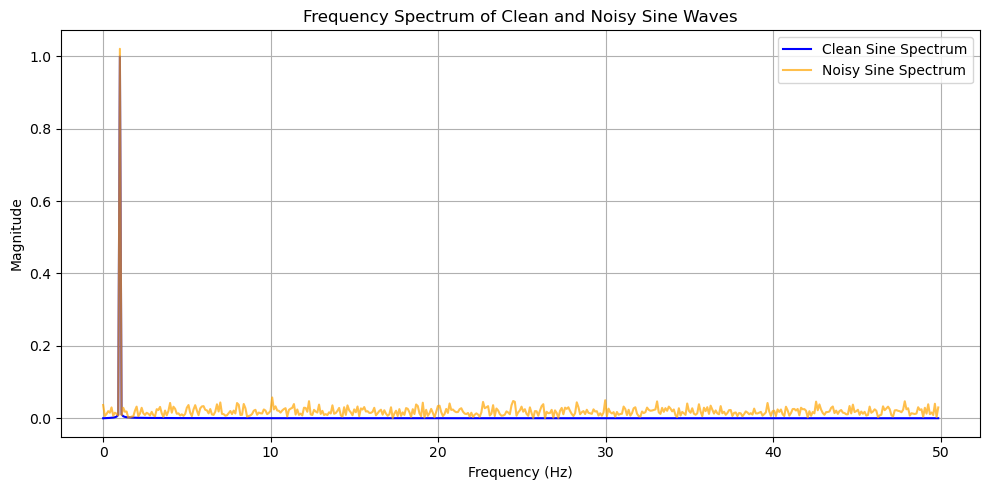

In [89]:
def jitter_study(frequency, amplitude, noise_factor, window_size):
    # Time vector: 100 points from 0 to 10
    t = np.linspace(0, 10, window_size)
    dt = t[1] - t[0]        # Time step
    fs = 1 / dt             # Sampling frequency

    # Generate clean sine wave
    sine_wave = amplitude * np.sin(2 * np.pi * frequency * t)

    # Generate zero-mean white noise
    noise = (np.random.rand(window_size) - 0.5) * 2 * noise_factor

    # Add noise
    noisy_signal = sine_wave + noise

    # FFT of both signals
    fft_clean = np.fft.fft(sine_wave)
    fft_noisy = np.fft.fft(noisy_signal)

    # Frequency axis
    freqs = np.fft.fftfreq(len(t), d=dt)

    # Take only the positive half of frequencies
    positive_freqs = freqs[:len(freqs)//2]
    spectrum_clean = np.abs(fft_clean[:len(freqs)//2])
    spectrum_noisy = np.abs(fft_noisy[:len(freqs)//2])

    # Plotting
    plt.figure(figsize=(10, 5))
    plt.plot(positive_freqs, spectrum_clean*(2/window_size), label='Clean Sine Spectrum', color='blue')
    plt.plot(positive_freqs, spectrum_noisy*(2/window_size), label='Noisy Sine Spectrum', color='orange', alpha=0.7)
    plt.title('Frequency Spectrum of Clean and Noisy Sine Waves')
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Magnitude')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()

    print(np.mean(spectrum_noisy[int(window_size*0.2):])*(2/(window_size**(0.5))))
    plt.show()

# Parameters
jitter_study(frequency = 1,          # Frequency of the sine wave (Hz)
             amplitude = 1.0,        # Amplitude of the sine wave
             noise_factor = 0.6,     # Scaling factor for the noise
             window_size = 1000)